In [1]:
#init system
import cv2
import numpy as np
import time
from PIL import Image as PIL_Image
from pynq import Overlay
from pynq.lib.video import *
base = Overlay("/home/xilinx/pynq/overlays/my_base/my_base.bit")

def showCvImage(cv_image):
    cv2.imwrite('__TEMP__.bmp',cv_image)     
    img = PIL_Image.open('__TEMP__.bmp')
    return img

def showNpImage(np_img_gray):
    x = cv2.cvtColor(np_img_gray.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    cv2.imwrite('__TEMP__.bmp',x)     
    img = PIL_Image.open('__TEMP__.bmp')
    return img

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


In [2]:
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

#1. start hdmi
Mode = VideoMode(1920,1080,8)
hdmi_out.configure(Mode)

#2 convert to gray
hdmi_in.configure(PIXEL_GRAY)

hdmi_in.start()
hdmi_out.start()

hdmi_in.tie(hdmi_out)

In [3]:
#test forward through PS
numframes = 30
start = time.time()
for _ in range(numframes):
    inframe0 = hdmi_in.readframe()
    hdmi_out.writeframe(inframe0)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  58.11718942327189


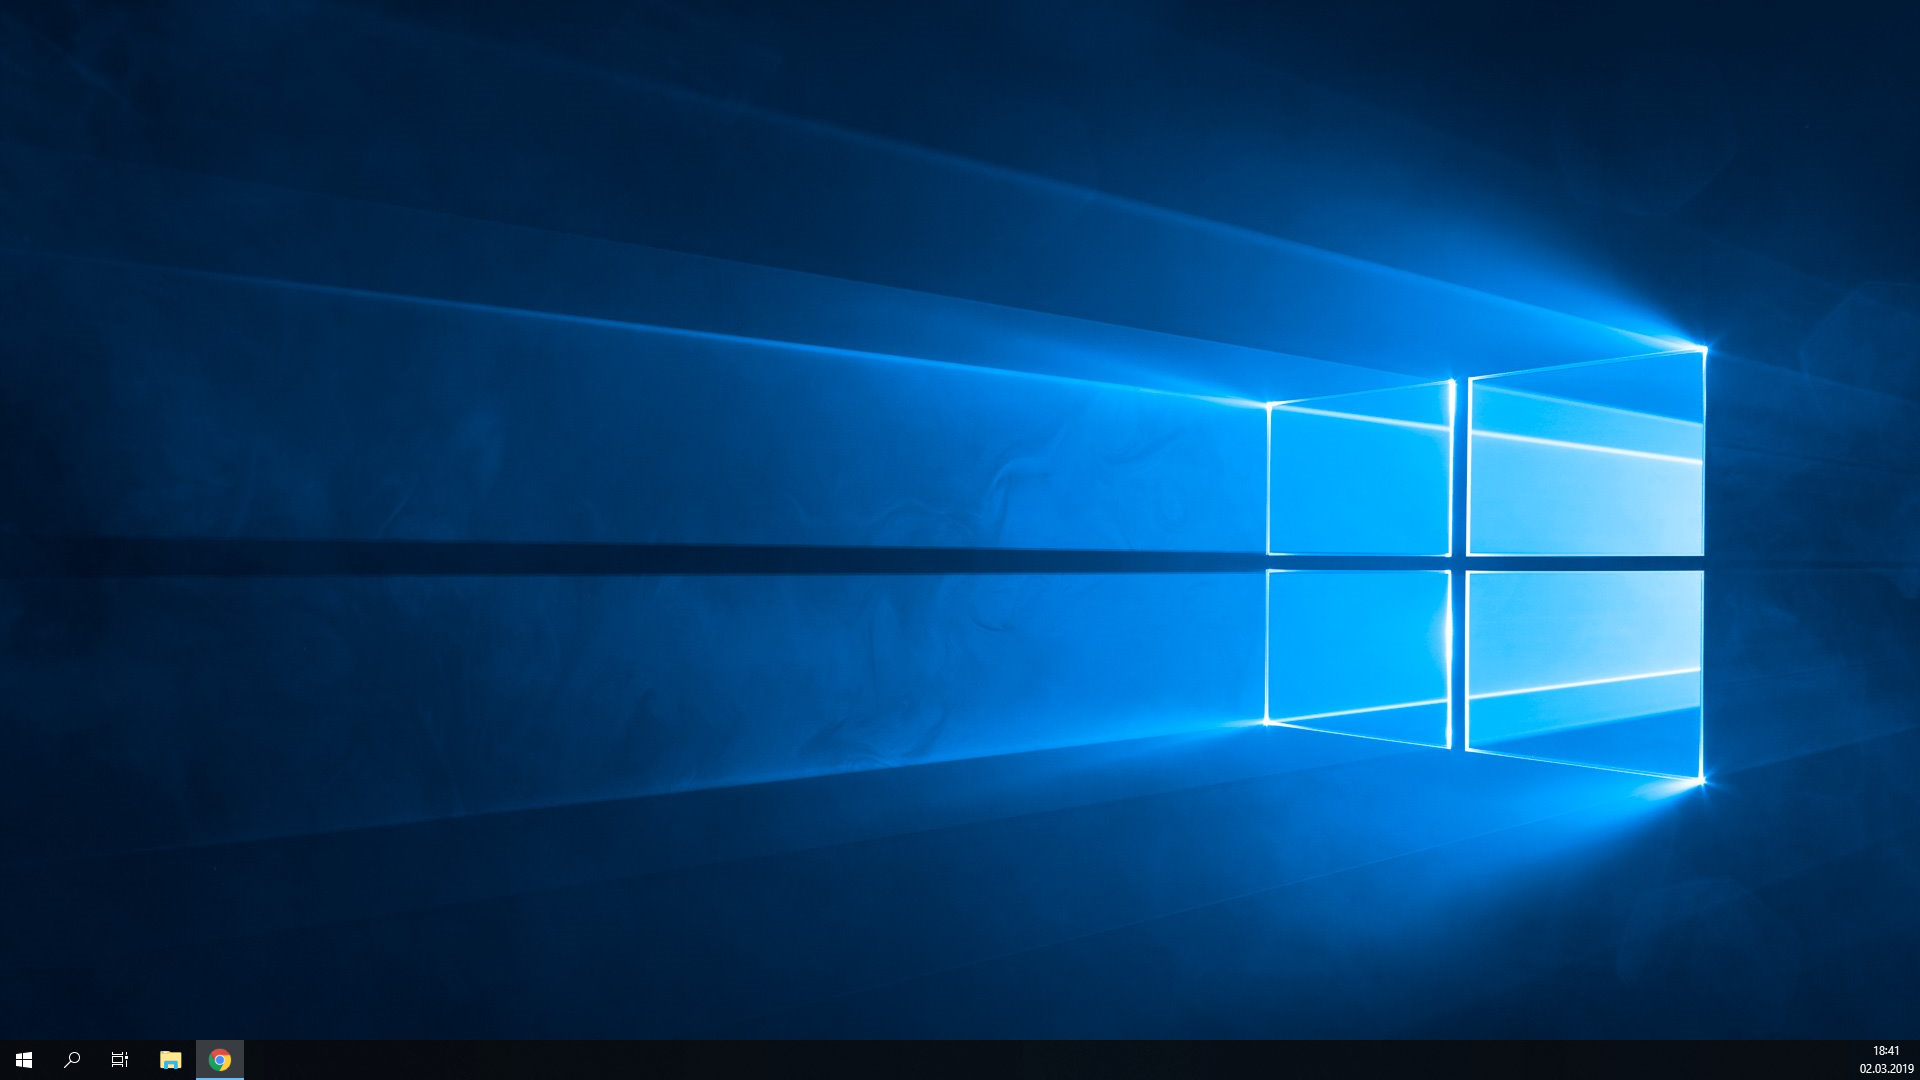

In [18]:
result_temp = np.ndarray(shape=(1080, 1920), dtype=np.uint8)
inframe0 = hdmi_in.readframe()

xx = showCvImage(inframe0); xx

In [4]:
outframe = hdmi_out.newframe()
hdmi_out.writeframe(outframe)

In [5]:
result = [np.ndarray(shape=(1080, 1920), dtype=np.uint8), np.ndarray(shape=(1080, 1920), dtype=np.uint8)]
result_temp = np.ndarray(shape=(1080, 1920), dtype=np.uint8)
def firstTheSimpliest(act_img, prev_img, outframe):
    #4 absdiff
    cv2.absdiff(prev_img, act_img, dst=result[0]);
    #5. threshold
    cv2.threshold(result[0], 35, 255, cv2.THRESH_BINARY, dst=outframe);
    
def firstWithDilate(act_img, prev_img, outframe):
    #4 absdiff
    cv2.absdiff(prev_img, act_img, dst=result[0]);
    #5. threshold
    cv2.threshold(result[0], 25, 255, cv2.THRESH_BINARY, dst=result[0]);
    #6. dilate
    cv2.dilate(result[0], None, iterations=2, dst=outframe);
    
def firstImproved(act_img, outframe, act_num, prev_num):
    #3. gaussian blur
    cv2.GaussianBlur(act_img,(5,5),0,dst=result[act_num]);
    #4 absdiff
    cv2.absdiff(result[prev_num], result[act_num], dst=result_temp);
    #5. threshold
    cv2.threshold(result_temp, 25, 255, cv2.THRESH_BINARY, dst=result_temp);
    #6. dilate
    cv2.dilate(result_temp, None, iterations=2, dst=outframe);
    
def firstImproved_noDilate(act_img, outframe, act_num, prev_num):
    #3. gaussian blur
    cv2.GaussianBlur(act_img,(5,5),0,dst=result[act_num]);
    #4 absdiff
    cv2.absdiff(result[prev_num], result[act_num], dst=result_temp);
    #5. threshold
    cv2.threshold(result_temp, 25, 255, cv2.THRESH_BINARY, dst=outframe);

In [9]:
#gray absdiff threshold
import time
import cv2
result = np.ndarray(shape=(1080, 1920), dtype=np.uint8)
outframe1 = hdmi_out.newframe()
outframe2 = hdmi_out.newframe()
#test the simpliest 1. st alg
numframes = 60
actPointer = 1
inframe1 = hdmi_in.readframe();
inframe2 = hdmi_in.readframe();
start = time.time()
for _ in range(int(numframes/2)):
    inframe1 = hdmi_in.readframe();
    #4 absdiff
    cv2.absdiff(inframe1, inframe2, dst=result);
    #5. threshold
    cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=outframe1);
    hdmi_out.writeframe(outframe1)
    inframe2 = hdmi_in.readframe();
    #4 absdiff
    cv2.absdiff(inframe1, inframe2, dst=result);
    #5. threshold
    cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=outframe2);
    hdmi_out.writeframe(outframe2)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  21.815259710116635


In [12]:
#gray absdiff threshold
start = time.time()
inframe1 = hdmi_in.readframe();
#4 absdiff
cv2.absdiff(inframe1, inframe2, dst=result);
#5. threshold
cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=outframe1);
hdmi_out.writeframe(outframe1)
end = time.time()
print("delay:  " + str((end - start)))

delay:  0.05516529083251953


In [13]:
#gray absdiff threshold dilate
import time
import cv2
result = np.ndarray(shape=(1080, 1920), dtype=np.uint8)
outframe1 = hdmi_out.newframe()
outframe2 = hdmi_out.newframe()
#test the simpliest 1. st alg
numframes = 60
actPointer = 1
inframe1 = hdmi_in.readframe();
inframe2 = hdmi_in.readframe();
start = time.time()
for _ in range(int(numframes/2)):
    inframe1 = hdmi_in.readframe();
    #4 absdiff
    cv2.absdiff(inframe1, inframe2, dst=result);
    #5. threshold
    cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=result);
    #6. dilate
    cv2.dilate(result, None, iterations=2, dst=outframe1);
    hdmi_out.writeframe(outframe1)
    inframe2 = hdmi_in.readframe();
    #4 absdiff
    cv2.absdiff(inframe1, inframe2, dst=result);
    #5. threshold
    cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=result);
    #6. dilate
    cv2.dilate(result, None, iterations=2, dst=outframe2);
    hdmi_out.writeframe(outframe2)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  4.916729467777994


In [14]:
start = time.time()
inframe1 = hdmi_in.readframe();
#4 absdiff
cv2.absdiff(inframe1, inframe2, dst=result);
#5. threshold
cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=result);
#6. dilate
cv2.dilate(result, None, iterations=2, dst=outframe1);
hdmi_out.writeframe(outframe1)
end = time.time()
print("delay:  " + str((end - start)))

delay:  0.19990062713623047


In [15]:
#gray gaussian absdiff threshold
import time
import cv2
result = np.ndarray(shape=(1080, 1920), dtype=np.uint8)
outframe1 = hdmi_out.newframe()
outframe2 = hdmi_out.newframe()
#test the simpliest 1. st alg
numframes = 60
actPointer = 1
inframe1 = hdmi_in.readframe();
inframe2 = hdmi_in.readframe();
start = time.time()
for _ in range(int(numframes/2)):
    inframe1 = hdmi_in.readframe();
    #3. gaussian blur
    cv2.GaussianBlur(inframe1,(5,5),0,dst=inframe1);
    #4 absdiff
    cv2.absdiff(inframe1, inframe2, dst=result);
    #5. threshold
    cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=outframe1);
    hdmi_out.writeframe(outframe1)
    inframe2 = hdmi_in.readframe();
    #3. gaussian blur
    cv2.GaussianBlur(inframe2,(5,5),0,dst=inframe2);
    #4 absdiff
    cv2.absdiff(inframe1, inframe2, dst=result);
    #5. threshold
    cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=outframe2);
    hdmi_out.writeframe(outframe2)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  4.636420373980417


In [16]:
start = time.time()
inframe1 = hdmi_in.readframe();
#3. gaussian blur
cv2.GaussianBlur(inframe1,(5,5),0,dst=inframe1);
#4 absdiff
cv2.absdiff(inframe1, inframe2, dst=result);
#5. threshold
cv2.threshold(result, 25, 255, cv2.THRESH_BINARY, dst=outframe1);
hdmi_out.writeframe(outframe1)
end = time.time()
print("delay:  " + str((end - start)))

delay:  0.23082494735717773
